In [1]:
from pathlib import Path
import itertools as it
import warnings

from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")

In [2]:
method_colours = {"com": "tab:green", "moc": "tab:orange"}
nseeds = 3

In [3]:
def get_summary(directory, max_seed):

    dfs = []
    for seed in range(max_seed):
        try:
            df = pd.read_csv(f"{directory}/{seed}/summary/main.csv")
            df["seed"] = seed
            dfs.append(df)
        except FileNotFoundError as err:
            print(err)

    main = pd.concat(dfs, axis=0, ignore_index=True)
    main = main.drop_duplicates(subset=["nrows", "ncols", "memory", "fitness", "seed"], keep="last")

    return main

In [99]:
com_dir = "../data/edo/cao_over_matching_final_cost"
com = get_summary(com_dir, nseeds)

com.shape

(35144, 7)

In [100]:
moc_dir = "../data/edo/matching_over_cao_final_cost"
moc = get_summary(moc_dir, nseeds)

moc.shape

(36372, 7)

# Top percentile across all generations

In [6]:
def get_best_percentiles(data, percentile):

    threshold = np.percentile(data["fitness"], percentile)
    return data[data["fitness"] < threshold]

In [108]:
com_percentile = get_best_percentiles(com, 1)
moc_percentile = get_best_percentiles(moc, 1)

com_percentile.shape, moc_percentile.shape

((352, 7), (364, 7))

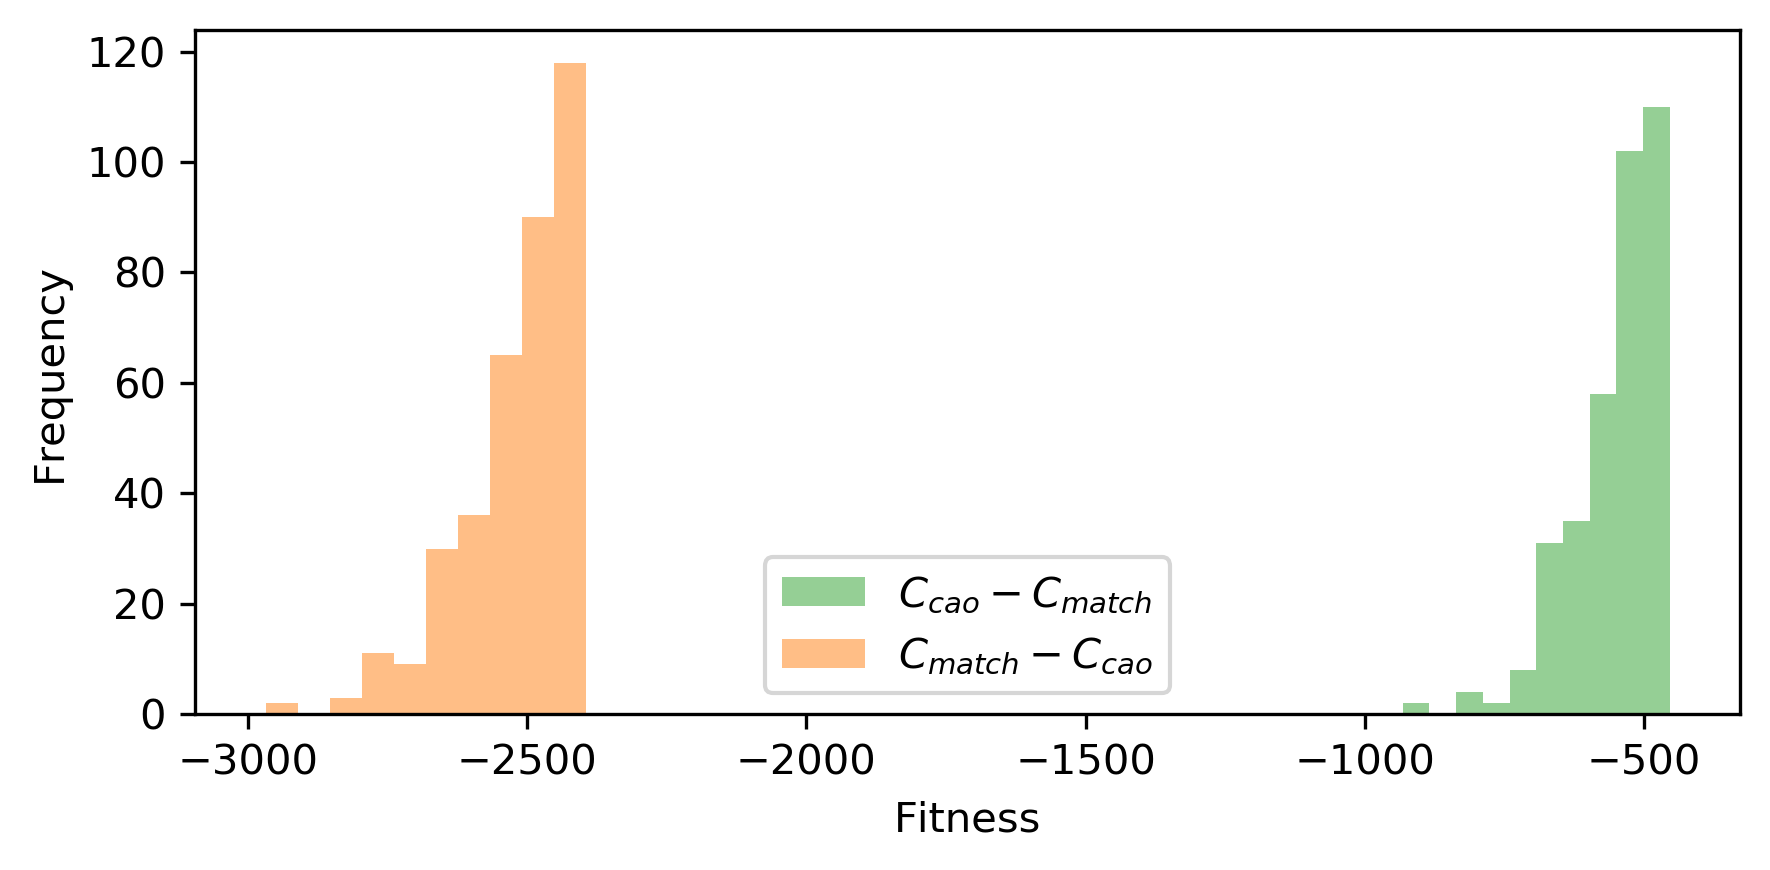

In [109]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

ax.hist(com_percentile["fitness"], color=method_colours["com"], alpha=0.5, label="$C_{cao} - C_{match}$")
ax.hist(moc_percentile["fitness"], color=method_colours["moc"], alpha=0.5, label="$C_{match} - C_{cao}$")

ax.set_xlabel("Fitness")
ax.set_ylabel("Frequency")

ax.legend()

plt.tight_layout()
plt.savefig("../img/edo/fitness.pdf", transparent=True)

Text(0, 0.5, 'Fitness')

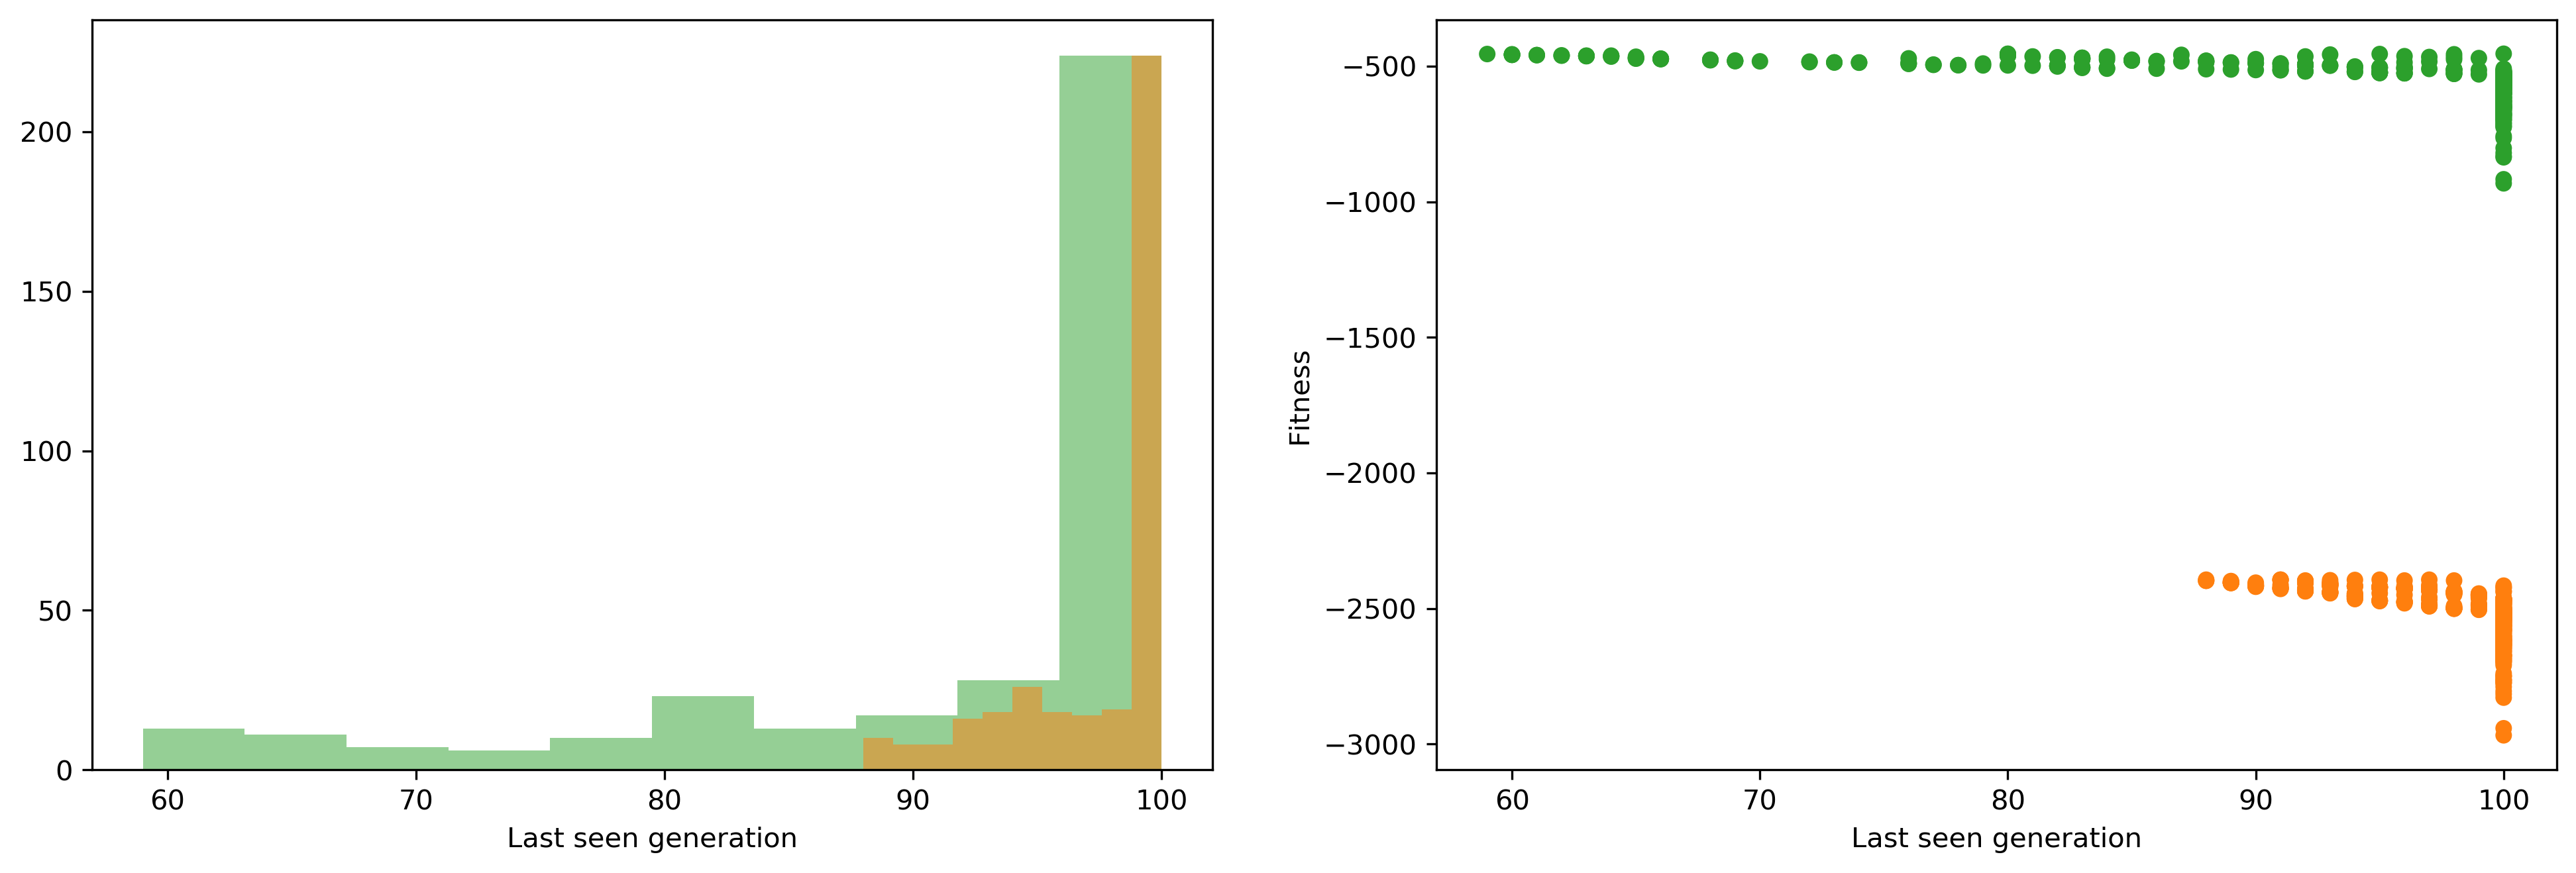

In [110]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5), dpi=300)

axes[0].hist(com_percentile["generation"], color=method_colours["com"], alpha=0.5, label="CoM")
axes[0].hist(moc_percentile["generation"], color=method_colours["moc"], alpha=0.5, label="MoC")
axes[0].set_xlabel("Last seen generation")

axes[1].scatter(
    com_percentile["generation"], com_percentile["fitness"], facecolor=method_colours["com"], edgecolor="None"
)
axes[1].scatter(
    moc_percentile["generation"], moc_percentile["fitness"], facecolor=method_colours["moc"], edgecolor="None"
)
axes[1].set_xlabel("Last seen generation")
axes[1].set_ylabel("Fitness")

In [111]:
def get_stats(data, root):

    dfs = []
    for _, row in data.astype(int).iterrows():

        seed = row["seed"]
        gen = row["generation"]
        ind = row["individual"]

        df = pd.read_csv(
            f"{root}/{seed}/data/{gen}/{ind}/main.csv", dtype=object
        )

        top_percentile_dir = Path(f"{root}/top_percentile/") / str(gen) / str(ind)
        top_percentile_dir.mkdir(parents=True, exist_ok=True)

        df.to_csv(
            top_percentile_dir / "main.csv", index=False
        )

        pca = PCA(n_components=1)
        data = pca.fit_transform(df)
        dfs.append(pd.DataFrame(data))

    variances, skews, kurtoses = [], [], []
    lower_deciles, upper_deciles, iqrs = [], [], []
    for df in dfs:
        variances += df.var().tolist()
        skews += stats.skew(df).tolist()
        kurtoses += stats.kurtosis(df).tolist()
        
        lower_deciles.append(np.percentile(df, 10))
        upper_deciles.append(np.percentile(df, 90))
        iqrs.append(stats.iqr(df))

    return {
        "variance": variances,
        "skewdness": skews,
        "kurtosis": kurtoses,
        "lower decile": lower_deciles,
        "upper decile": upper_deciles,
        "interquartile range": iqrs,
    }

In [112]:
com_stats = get_stats(com_percentile, com_dir)
moc_stats = get_stats(moc_percentile, moc_dir)

In [115]:
def get_best_distribution(values, bins=200):

    ys, xs = np.histogram(values, bins, density=True)
    xs = (xs + np.roll(xs, -1))[:-1] / 2

    distribution_names = [
        "norm", 
#         "beta",
        "chi2",
        "erlang",
        "f",
        "gamma",
#         "lognorm",
#         "pareto",
#         "rayleigh",
        "uniform",
#         "logistic"
    ]

    best_distribution = stats.norm
    best_params = (0, 1)
    best_sse = np.inf
    for name in distribution_names:

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")

            dist = getattr(stats, name)
            
            try:
                params = dist.fit(values)
                args = params[:-2]
                loc, scale = params[-2:]

                pdf = dist.pdf(xs, loc=loc, scale=scale, *args)
                sse = np.sum(np.power(ys - pdf, 2))

                if best_sse > sse > 0:
                    best_distribution = dist
                    best_params = params
                    best_sse = sse

            except Exception:
                pass

    return best_distribution, best_params


def get_pdf(dist, params, values, steps=300):

    args = params[:-2]
    loc, scale = params[-2:]

    if args:
        start = dist.ppf(0.001, *args, loc=loc, scale=scale)
        end = dist.ppf(0.999, *args, loc=loc, scale=scale)
    else:
        start = dist.ppf(0.001, loc=loc, scale=scale)
        end = dist.ppf(0.999, loc=loc, scale=scale)

    xs = np.linspace(min(values), max(values), steps)
    ys = dist.pdf(xs, loc=loc, scale=scale, *args)

    return pd.Series(ys, xs)


def hist_with_dist_plot(statistic, filename=None):
    
    fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

    for values, colour, label in zip(
        [com_stats[statistic], moc_stats[statistic]],
        list(method_colours.values()),
        ["$C_{cao} - C_{match}$", "$C_{match} - C_{cao}$"],
    ):
        ax.hist(
            values,
            color=colour,
            alpha=0.5,
            label=label,
            density=True,
        )

    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    for values, colour in zip(
        [com_stats[statistic], moc_stats[statistic]],
        list(method_colours.values()),
    ):
        dist, params = get_best_distribution(values)
        pdf = get_pdf(dist, params, values)

        label = f"{dist.name.capitalize().replace('2', '-squared')}"
        param_labels = []
        for i, param in enumerate(params):
            param = str(round(param, 1))
            diff = i - len(params)
            if diff == -2:
                param = "loc=" + param
            elif diff == -1:
                param = "scale=" + param

            param_labels.append(param)

        label += f"({', '.join(param_labels)})"
        
        ax.plot(pdf, lw=3, color=colour, label=label)

    ax.set_xlabel(statistic.capitalize())
    ax.set_ylabel("Density")

    ax.legend()
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename, transparent=True)


/Users/henrywilde/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(9.77821019).
  RuntimeWarning)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(503.8679752).
  RuntimeWarning)


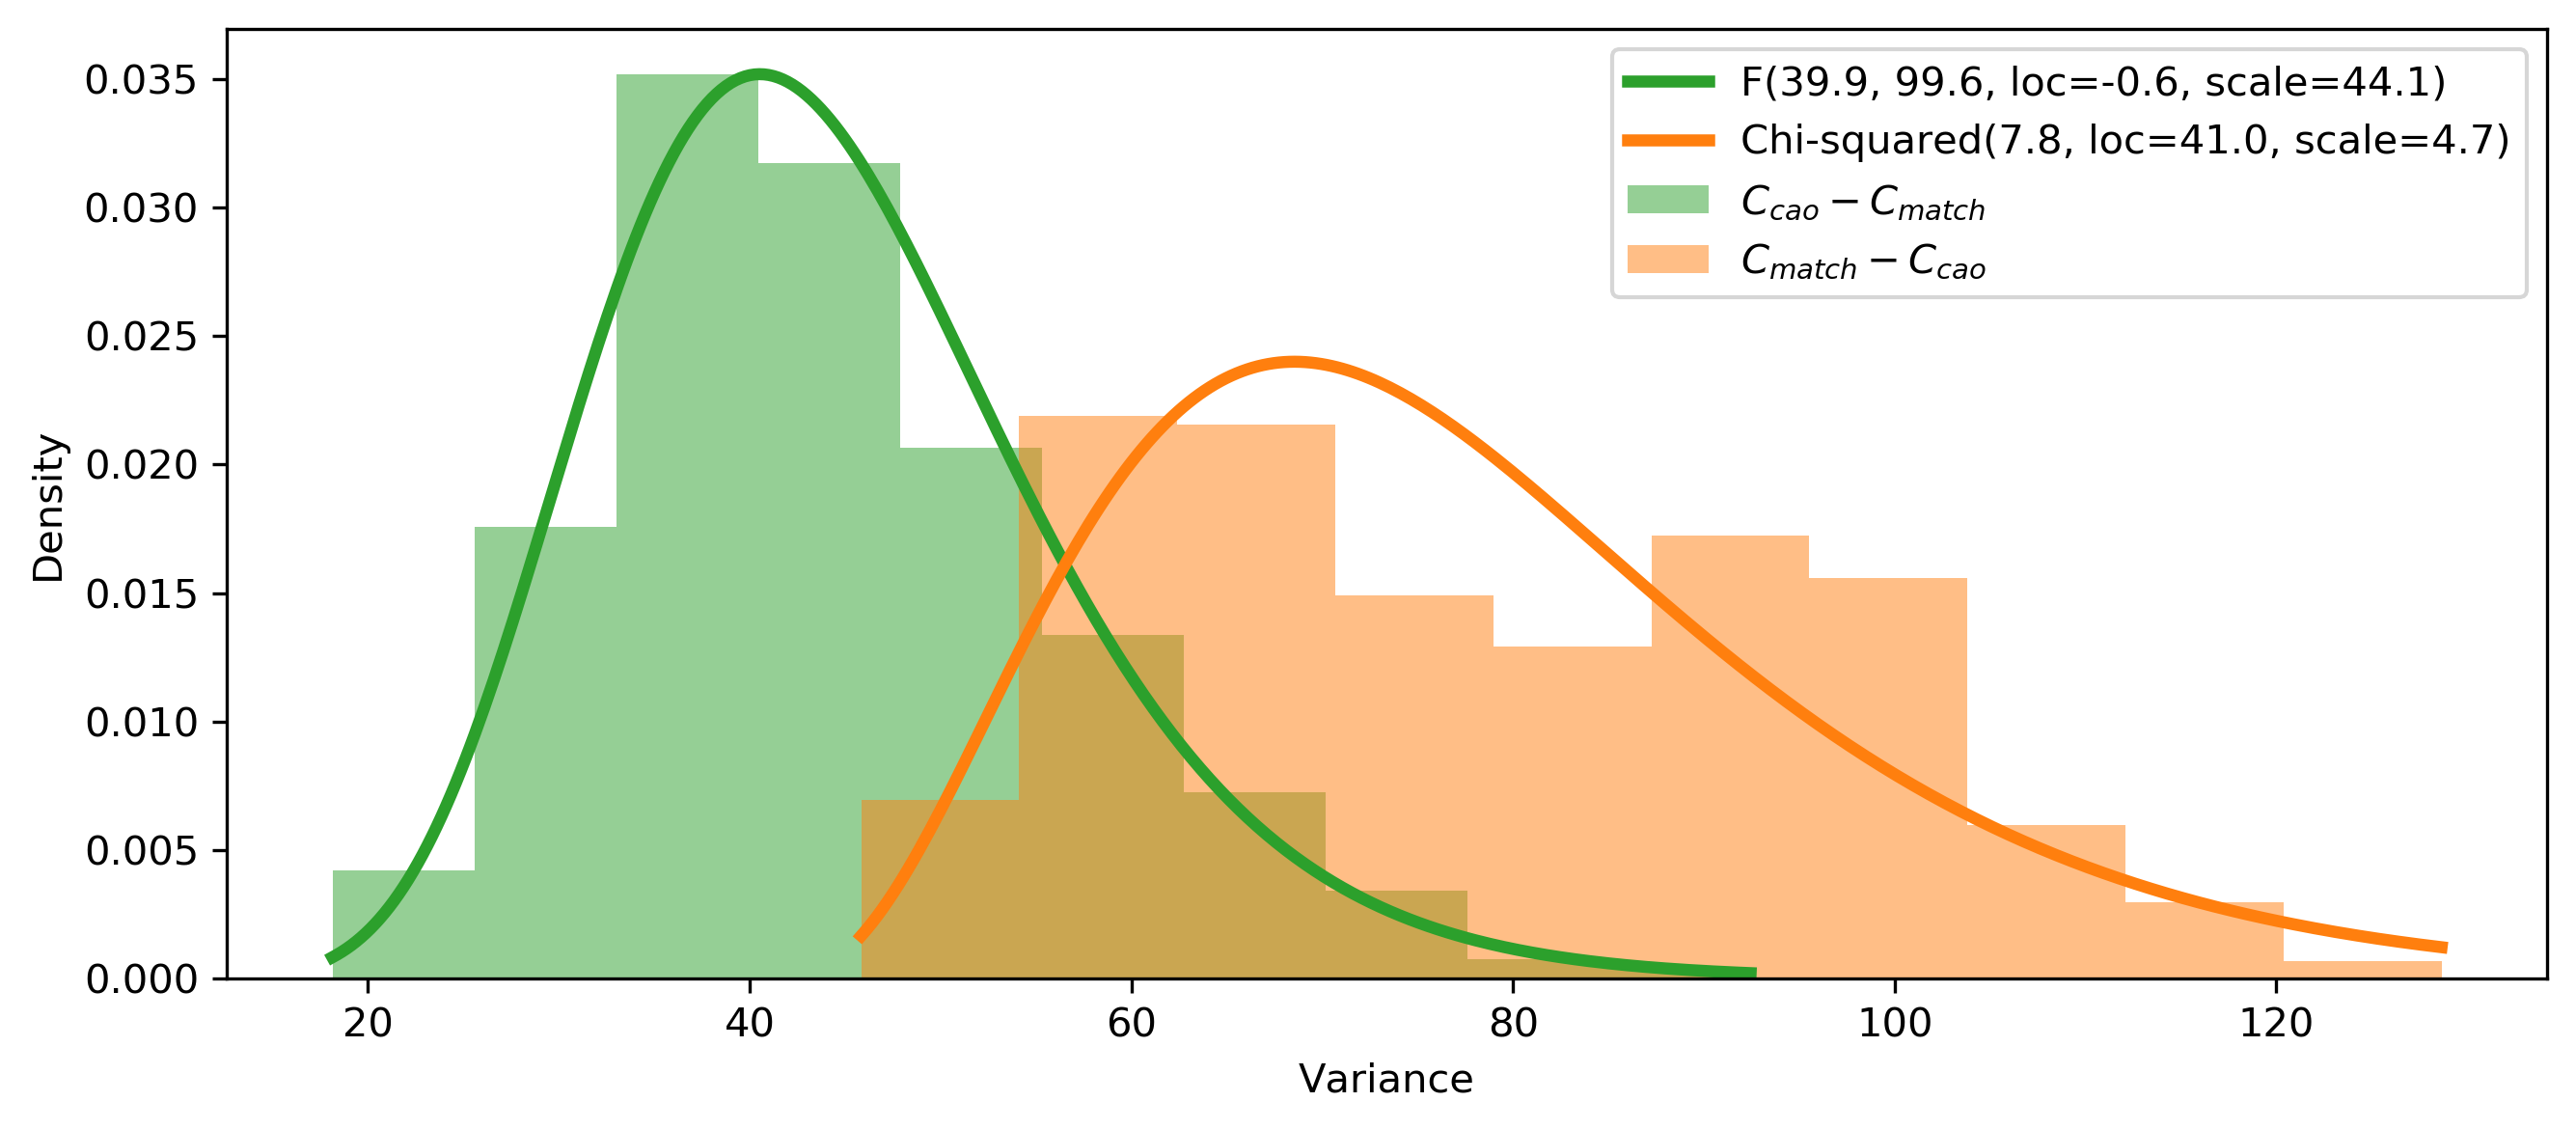

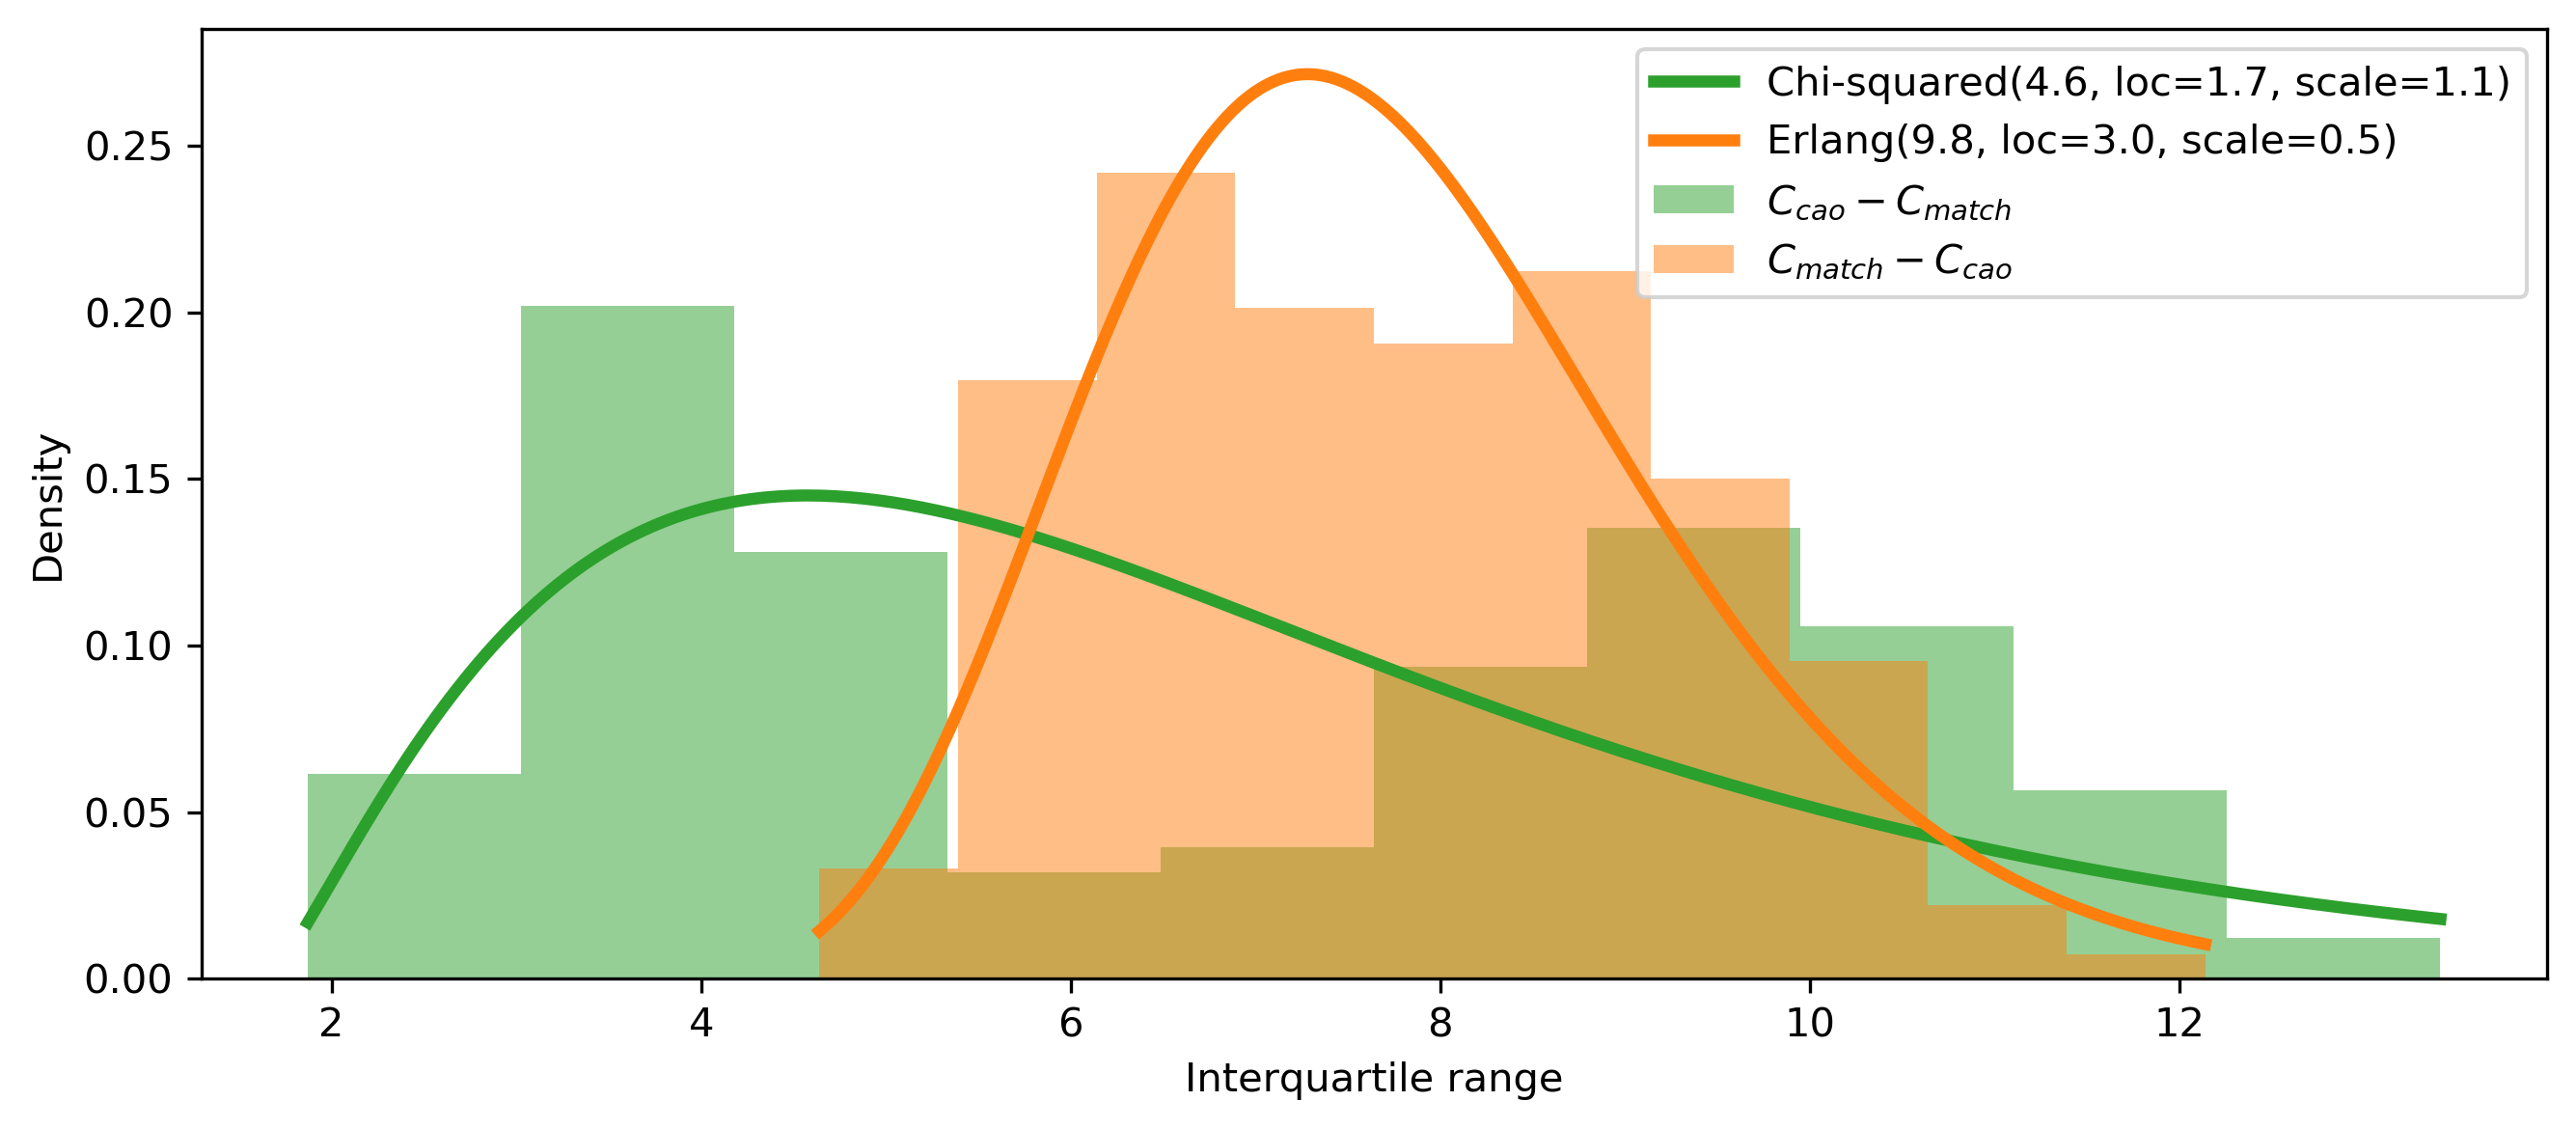

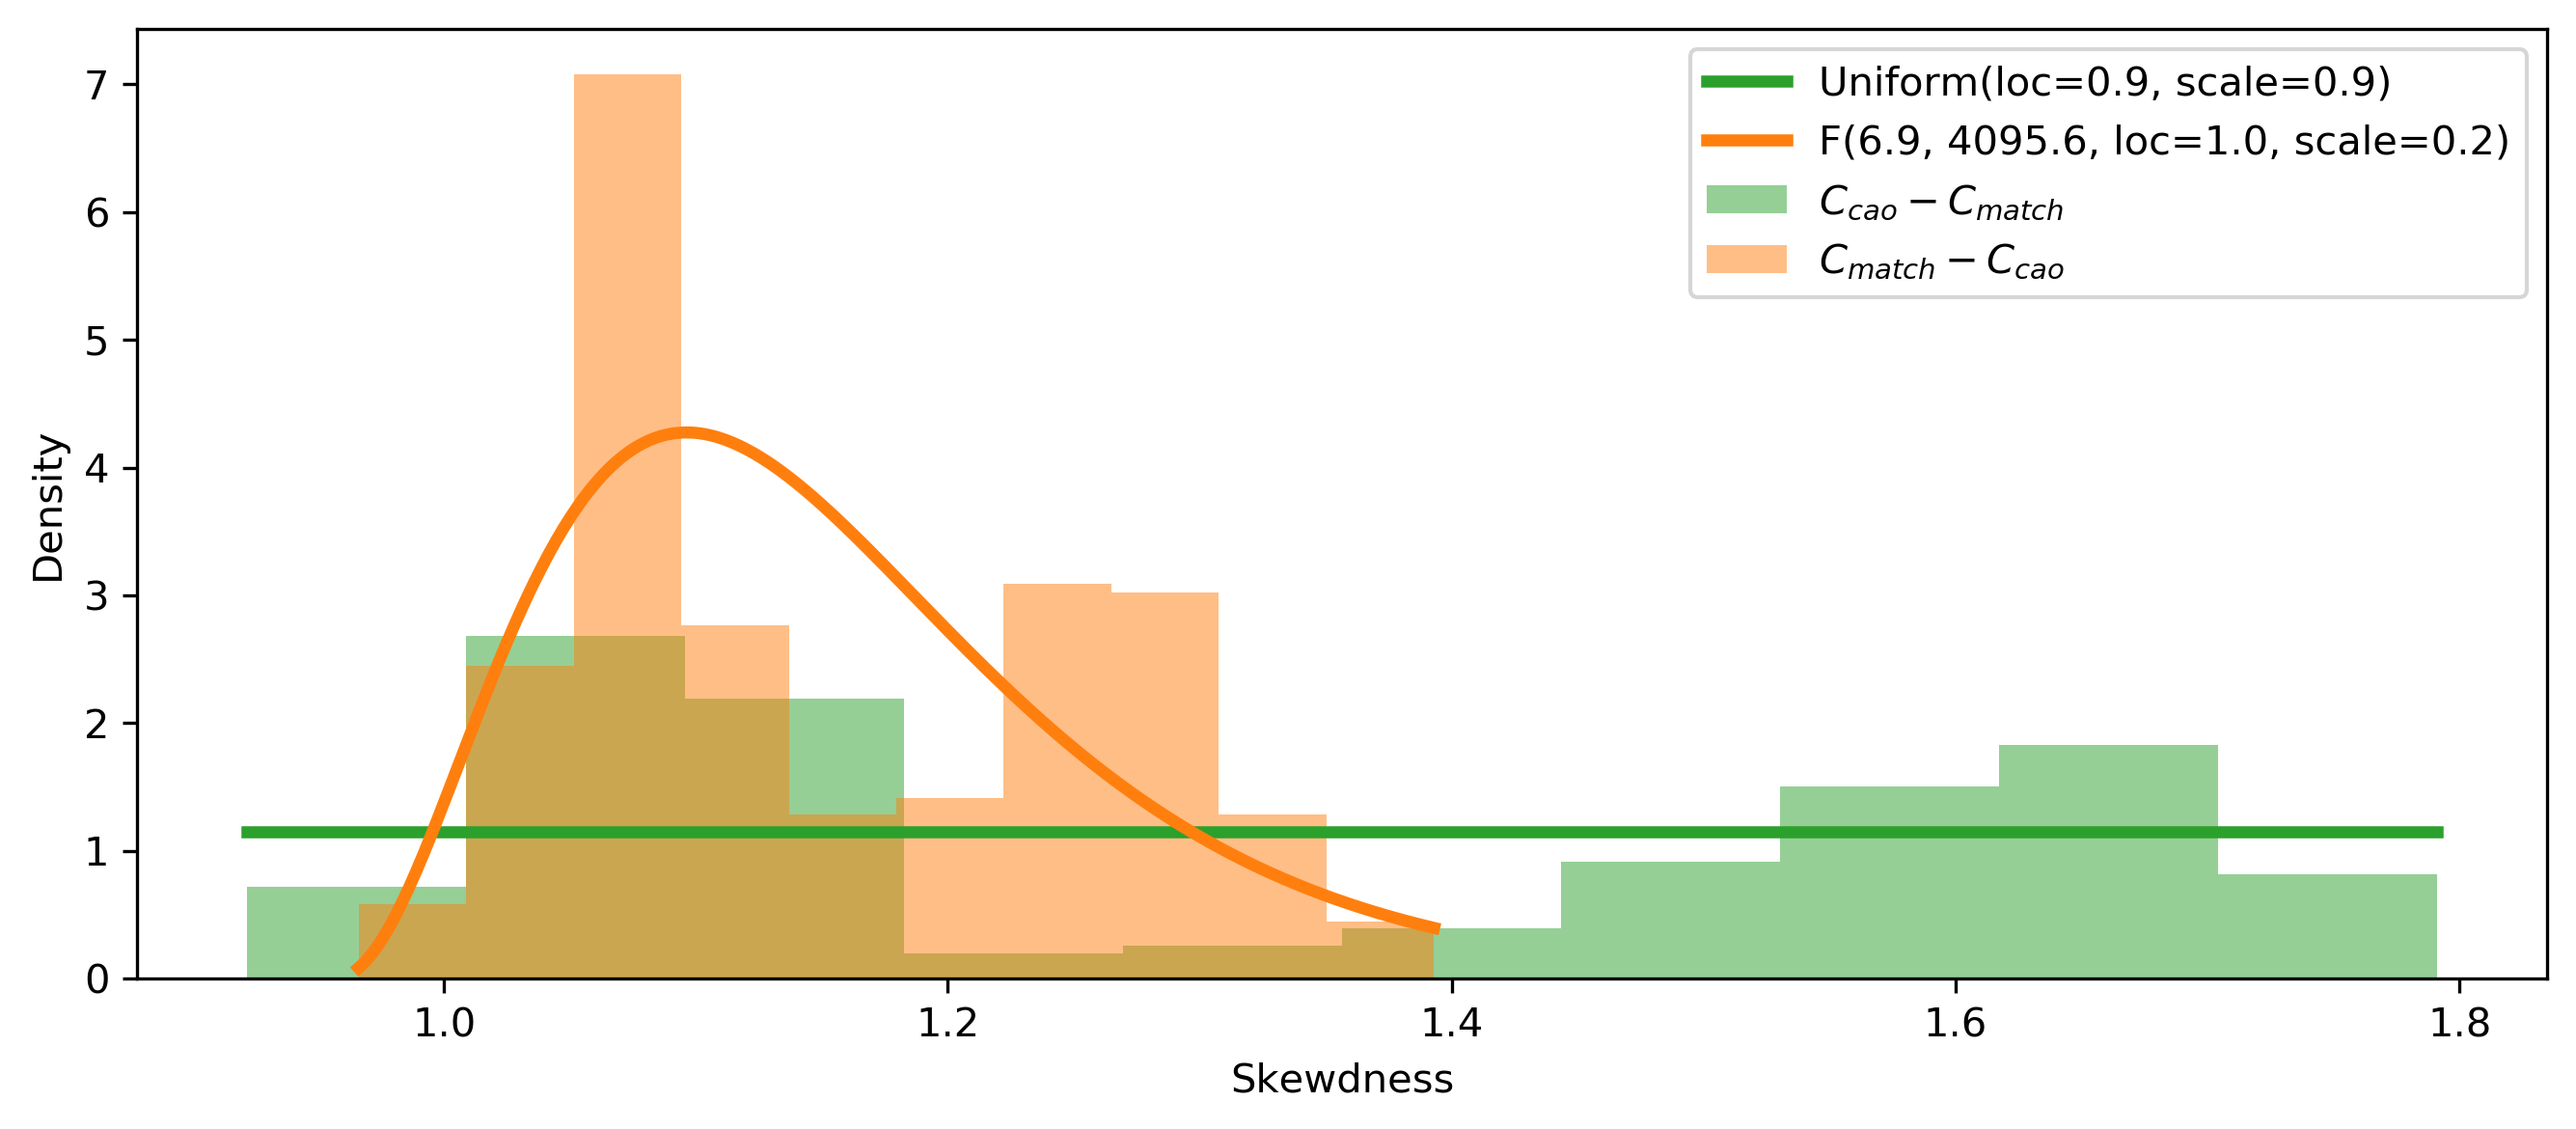

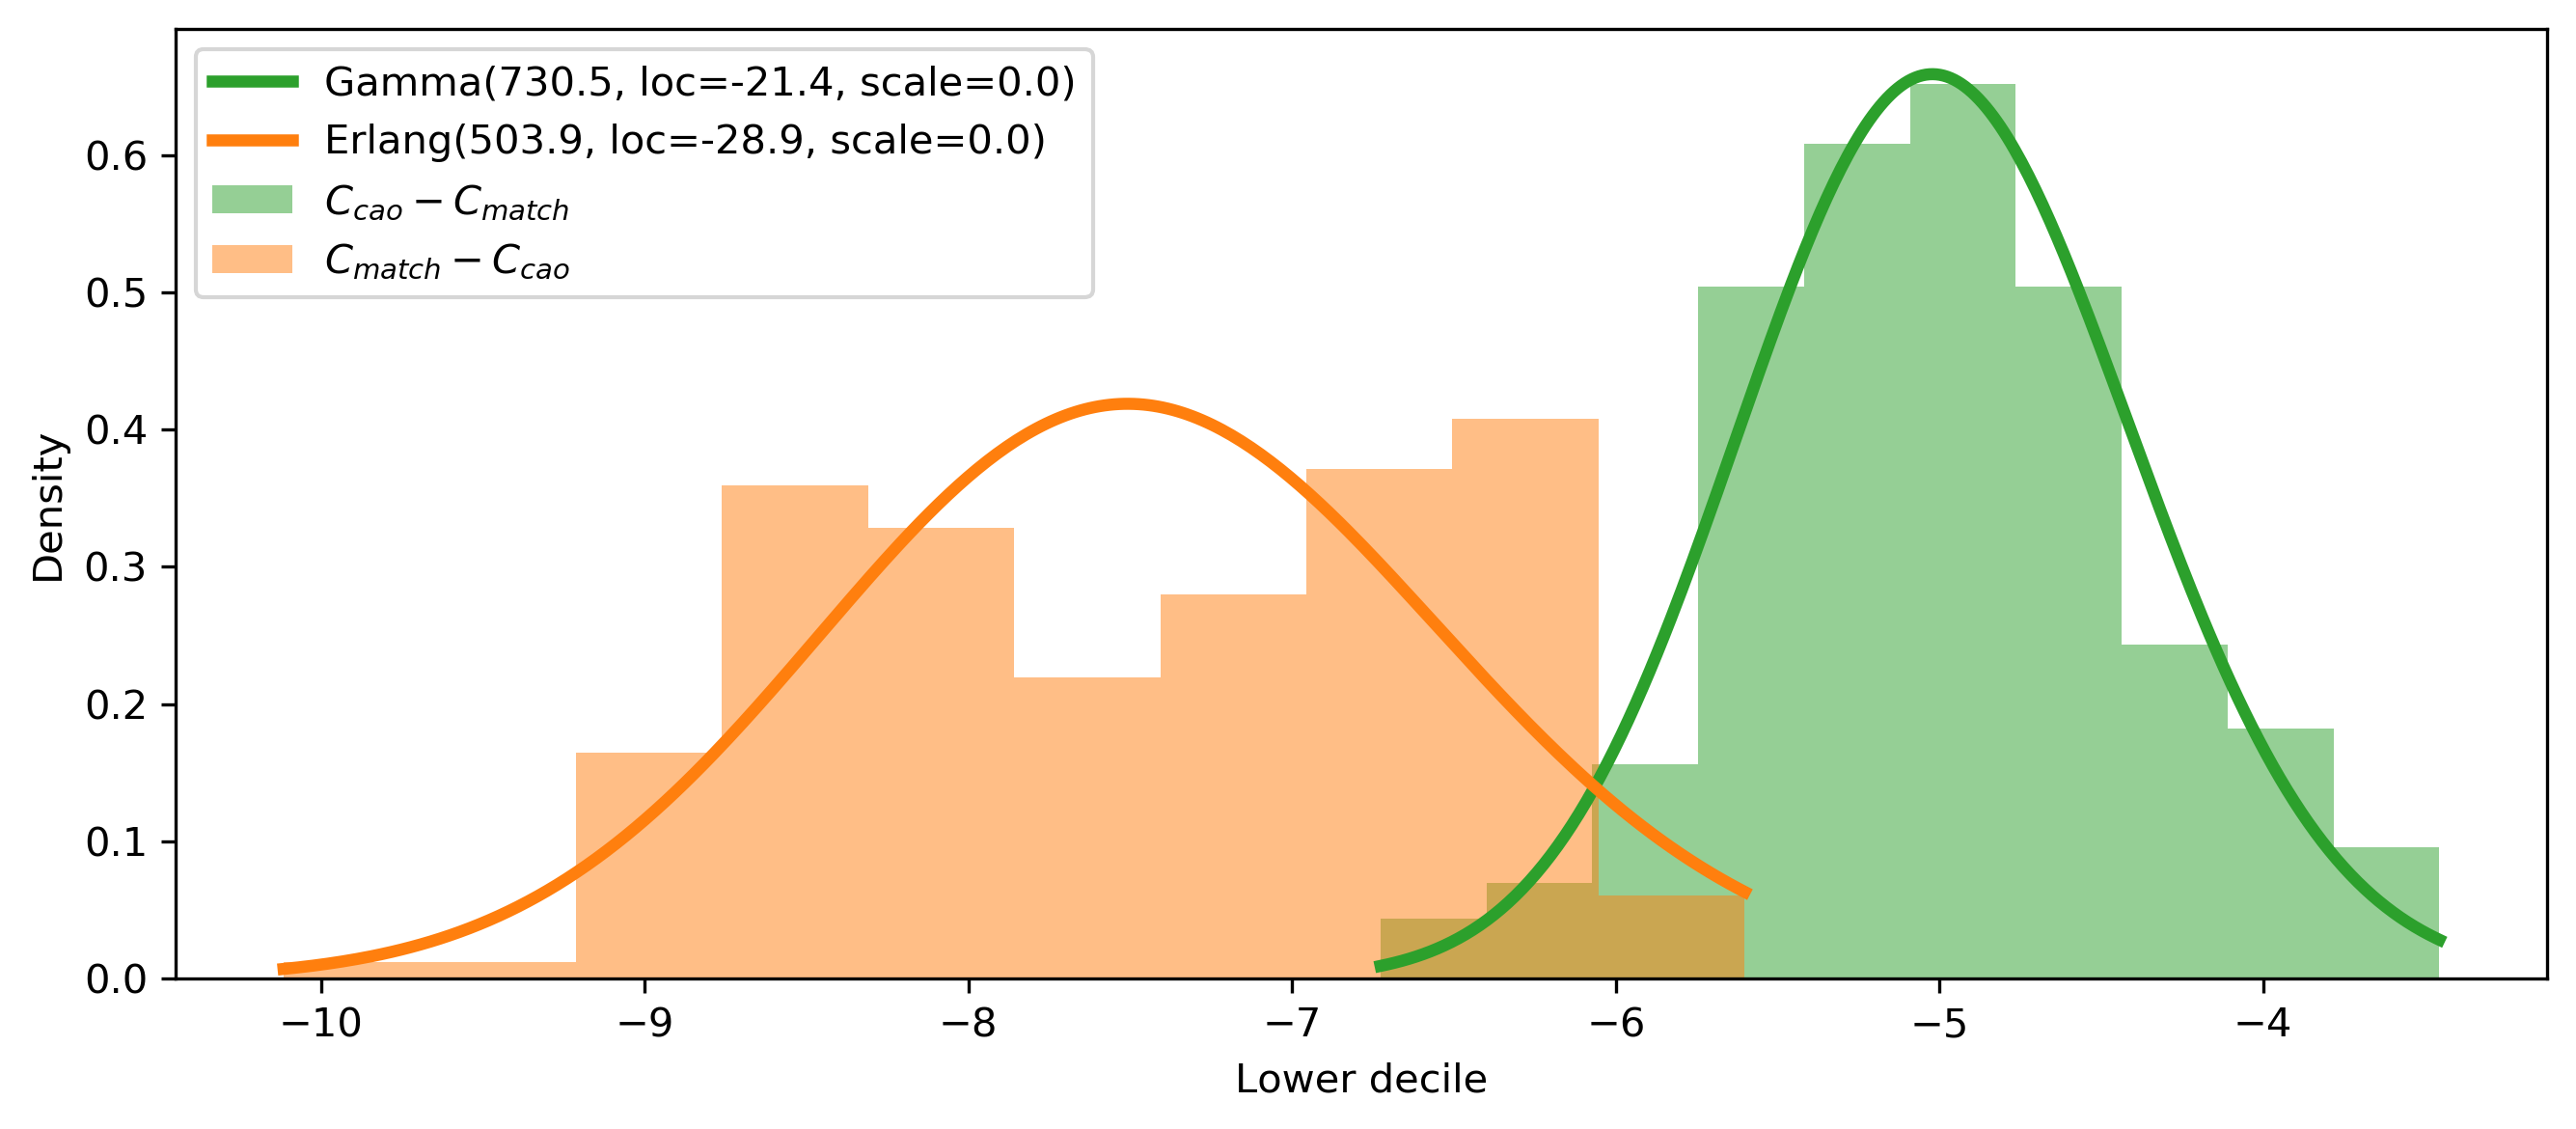

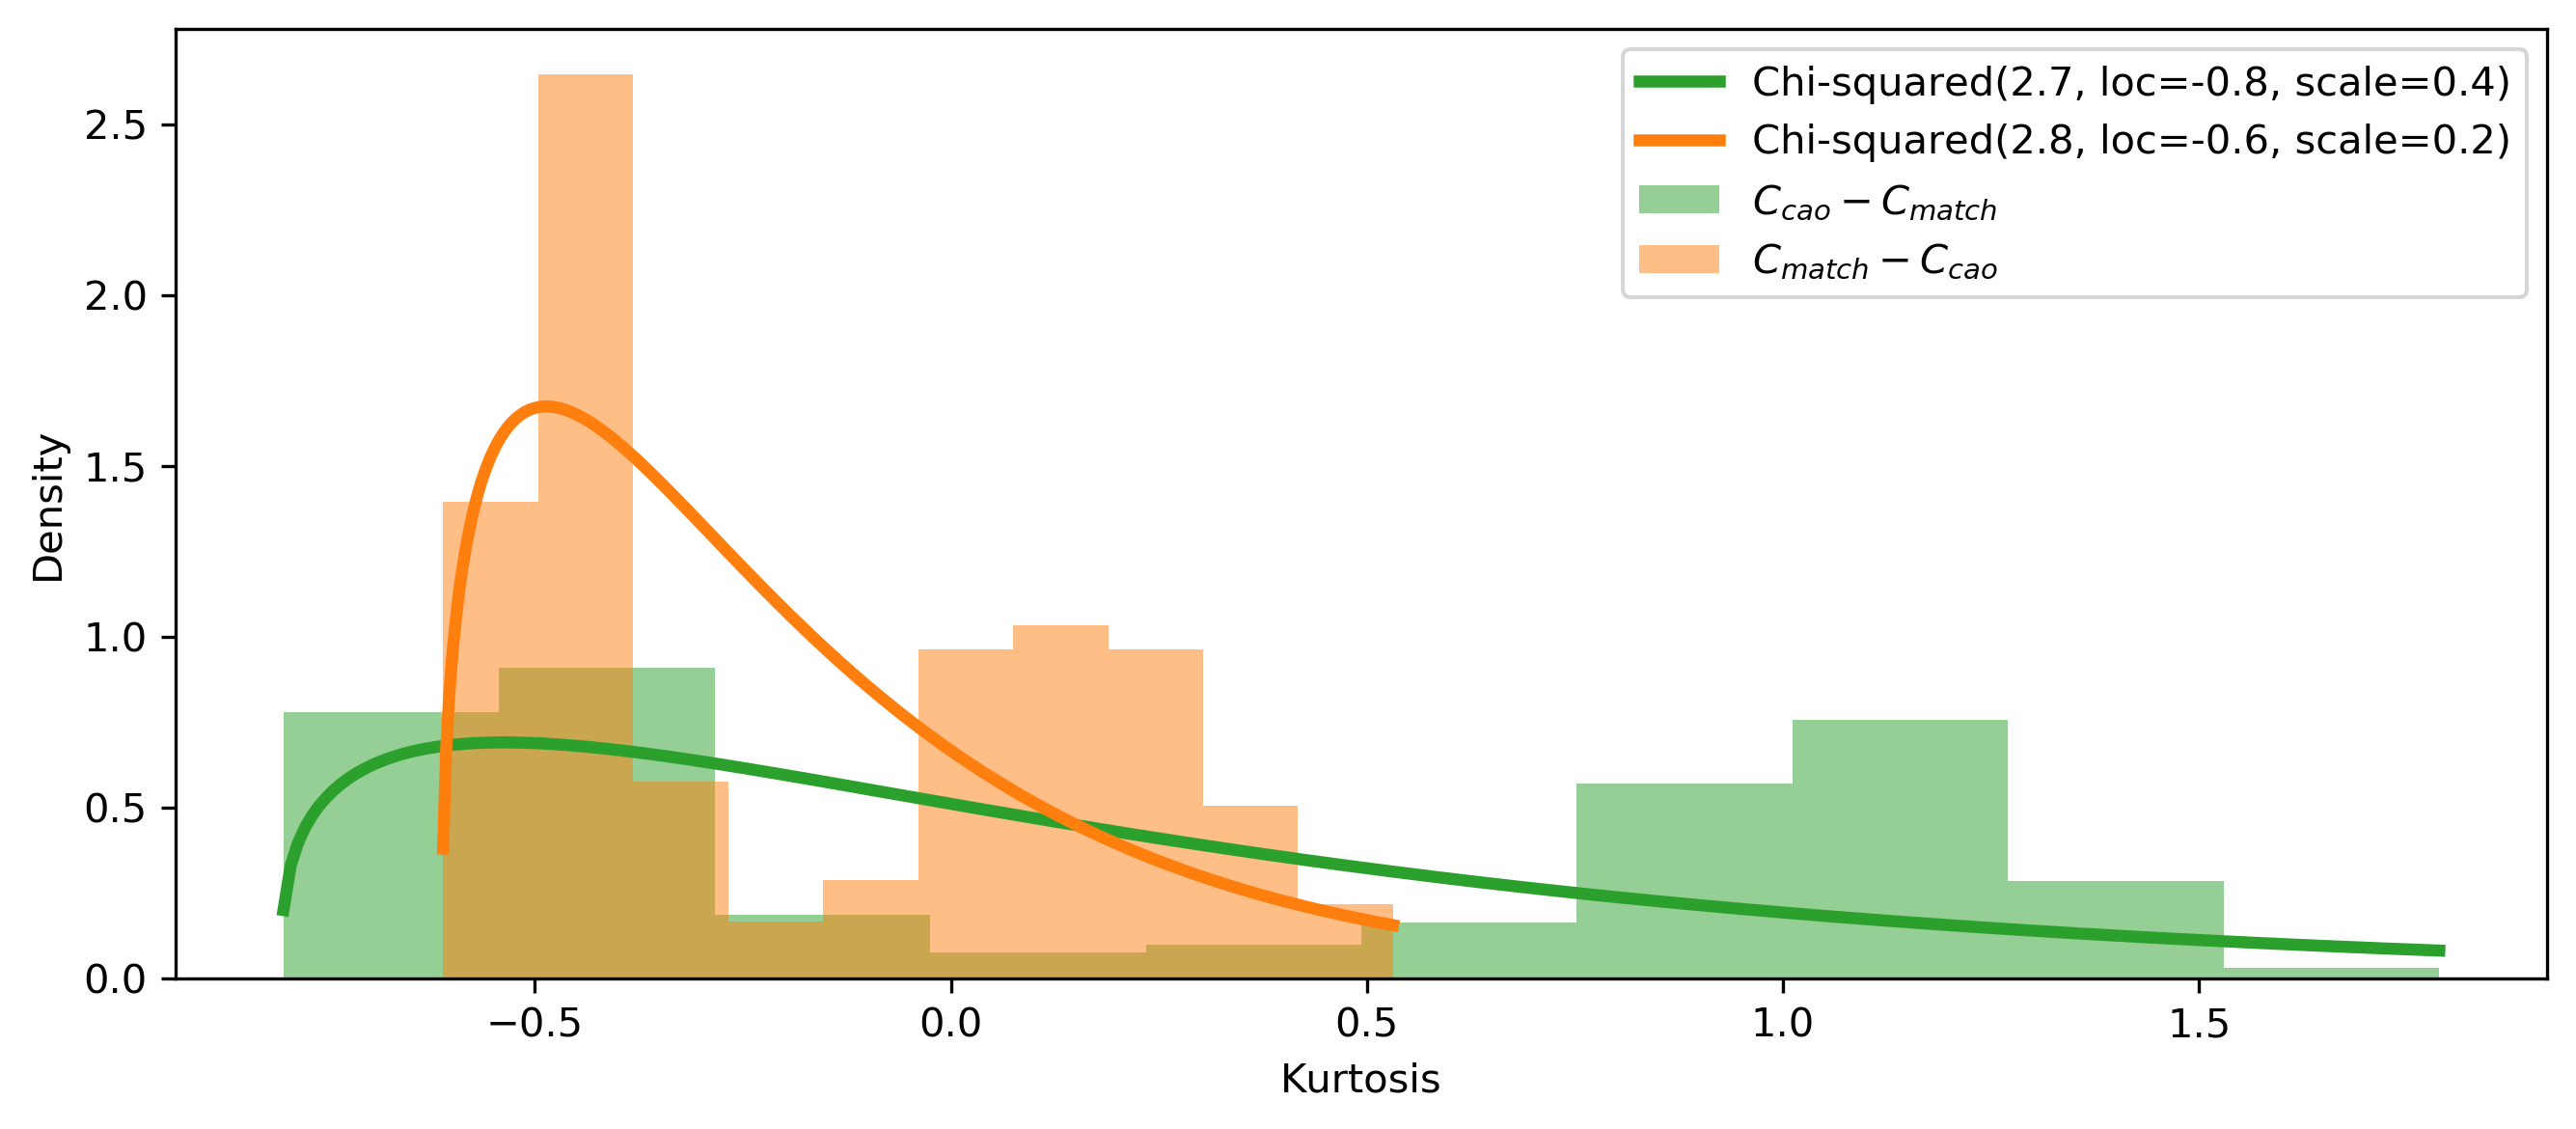

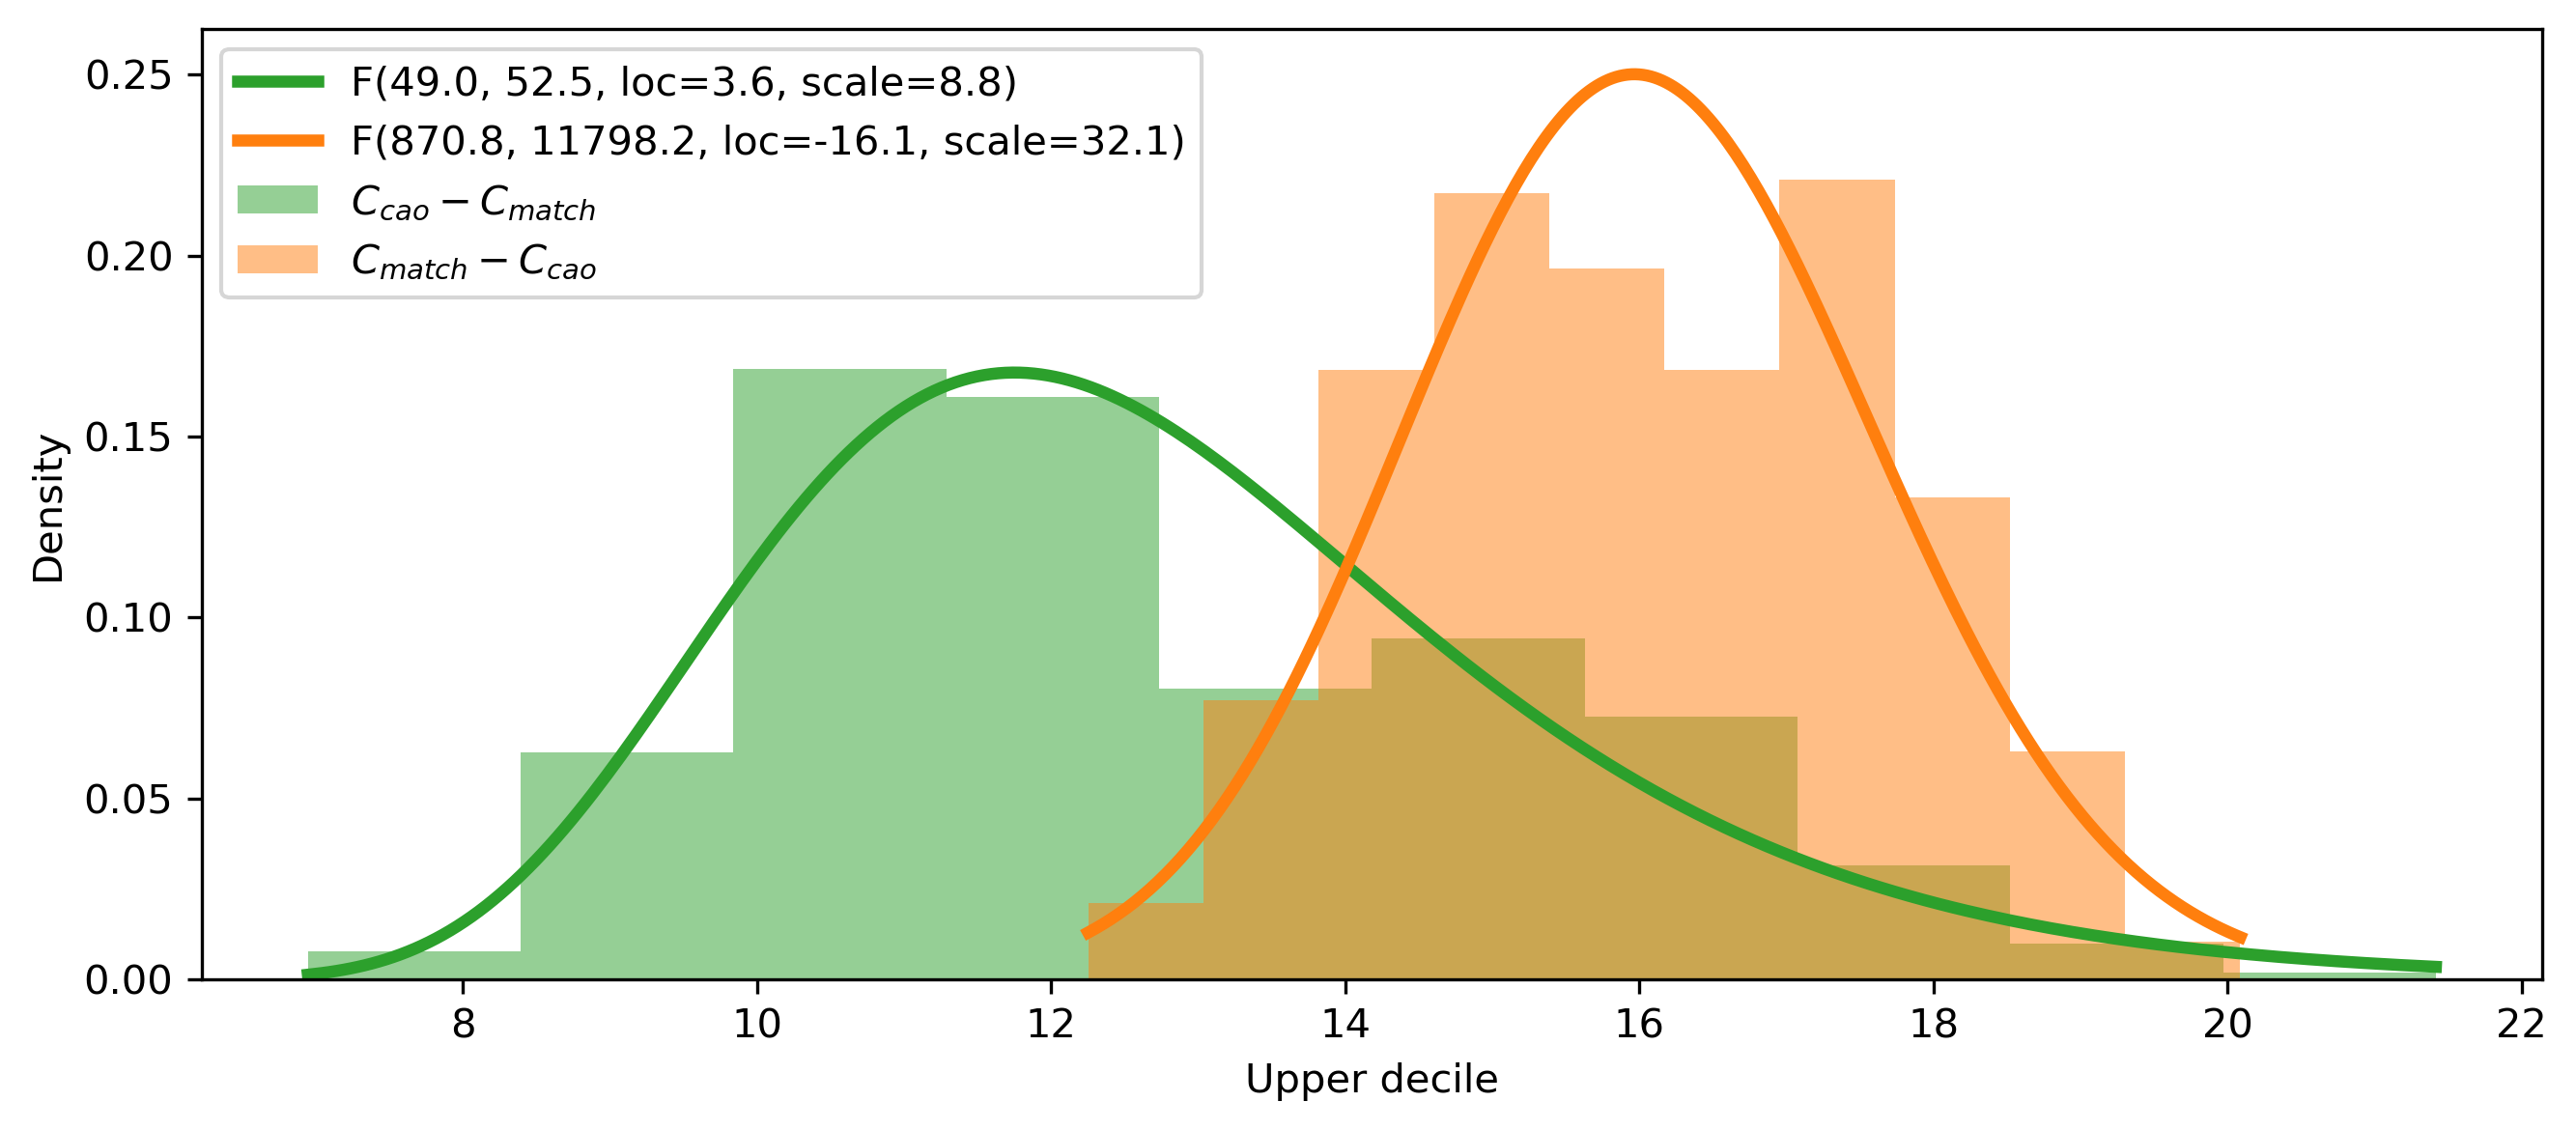

In [116]:
for stat in (
    "variance", "interquartile range",
    "skewdness", "lower decile",
    "kurtosis", "upper decile"
):
    hist_with_dist_plot(stat, f"../img/edo/{stat.replace(' ', '_')}.pdf")

In [14]:
def pair_plot(statistics, colour, cmap=plt.cm.viridis_r, filename=None):

    nstats = len(statistics)
    fig, axes = plt.subplots(nrows=nstats, ncols=nstats, figsize=(12, 12), dpi=200)

    axes = axes.T
    for i, j in it.product(range(nstats), repeat=2):
        ax = axes[i, j]
        xstat, xvalues = list(statistics.items())[i]
        ystat, yvalues = list(statistics.items())[j]

        if j < i:
            ax.set_axis_off()

        elif i == j:
            ax.hist(xvalues, color=colour, alpha=0.5)

        else:
            nbins = 500
            X, Y = np.mgrid[
                min(xvalues):max(xvalues):nbins*1j,
                min(yvalues):max(yvalues):nbins*1j
            ]
            positions = np.vstack([X.ravel(), Y.ravel()])
            values = np.vstack([xvalues, yvalues])

            kernel = stats.kde.gaussian_kde(values)
            Z = np.reshape(kernel(positions).T, X.shape)

            ax.contourf(X, Y, Z, cmap=cmap)

        if j == nstats - 1:
            ax.set_xlabel(xstat.capitalize())
        else:
            ax.set_xticklabels([])
        if i == 0:
            ax.set_ylabel(ystat.capitalize())
        else:
            ax.set_yticklabels([])

    plt.tight_layout()
    if filename:
        plt.savefig(filename, transparent=True)

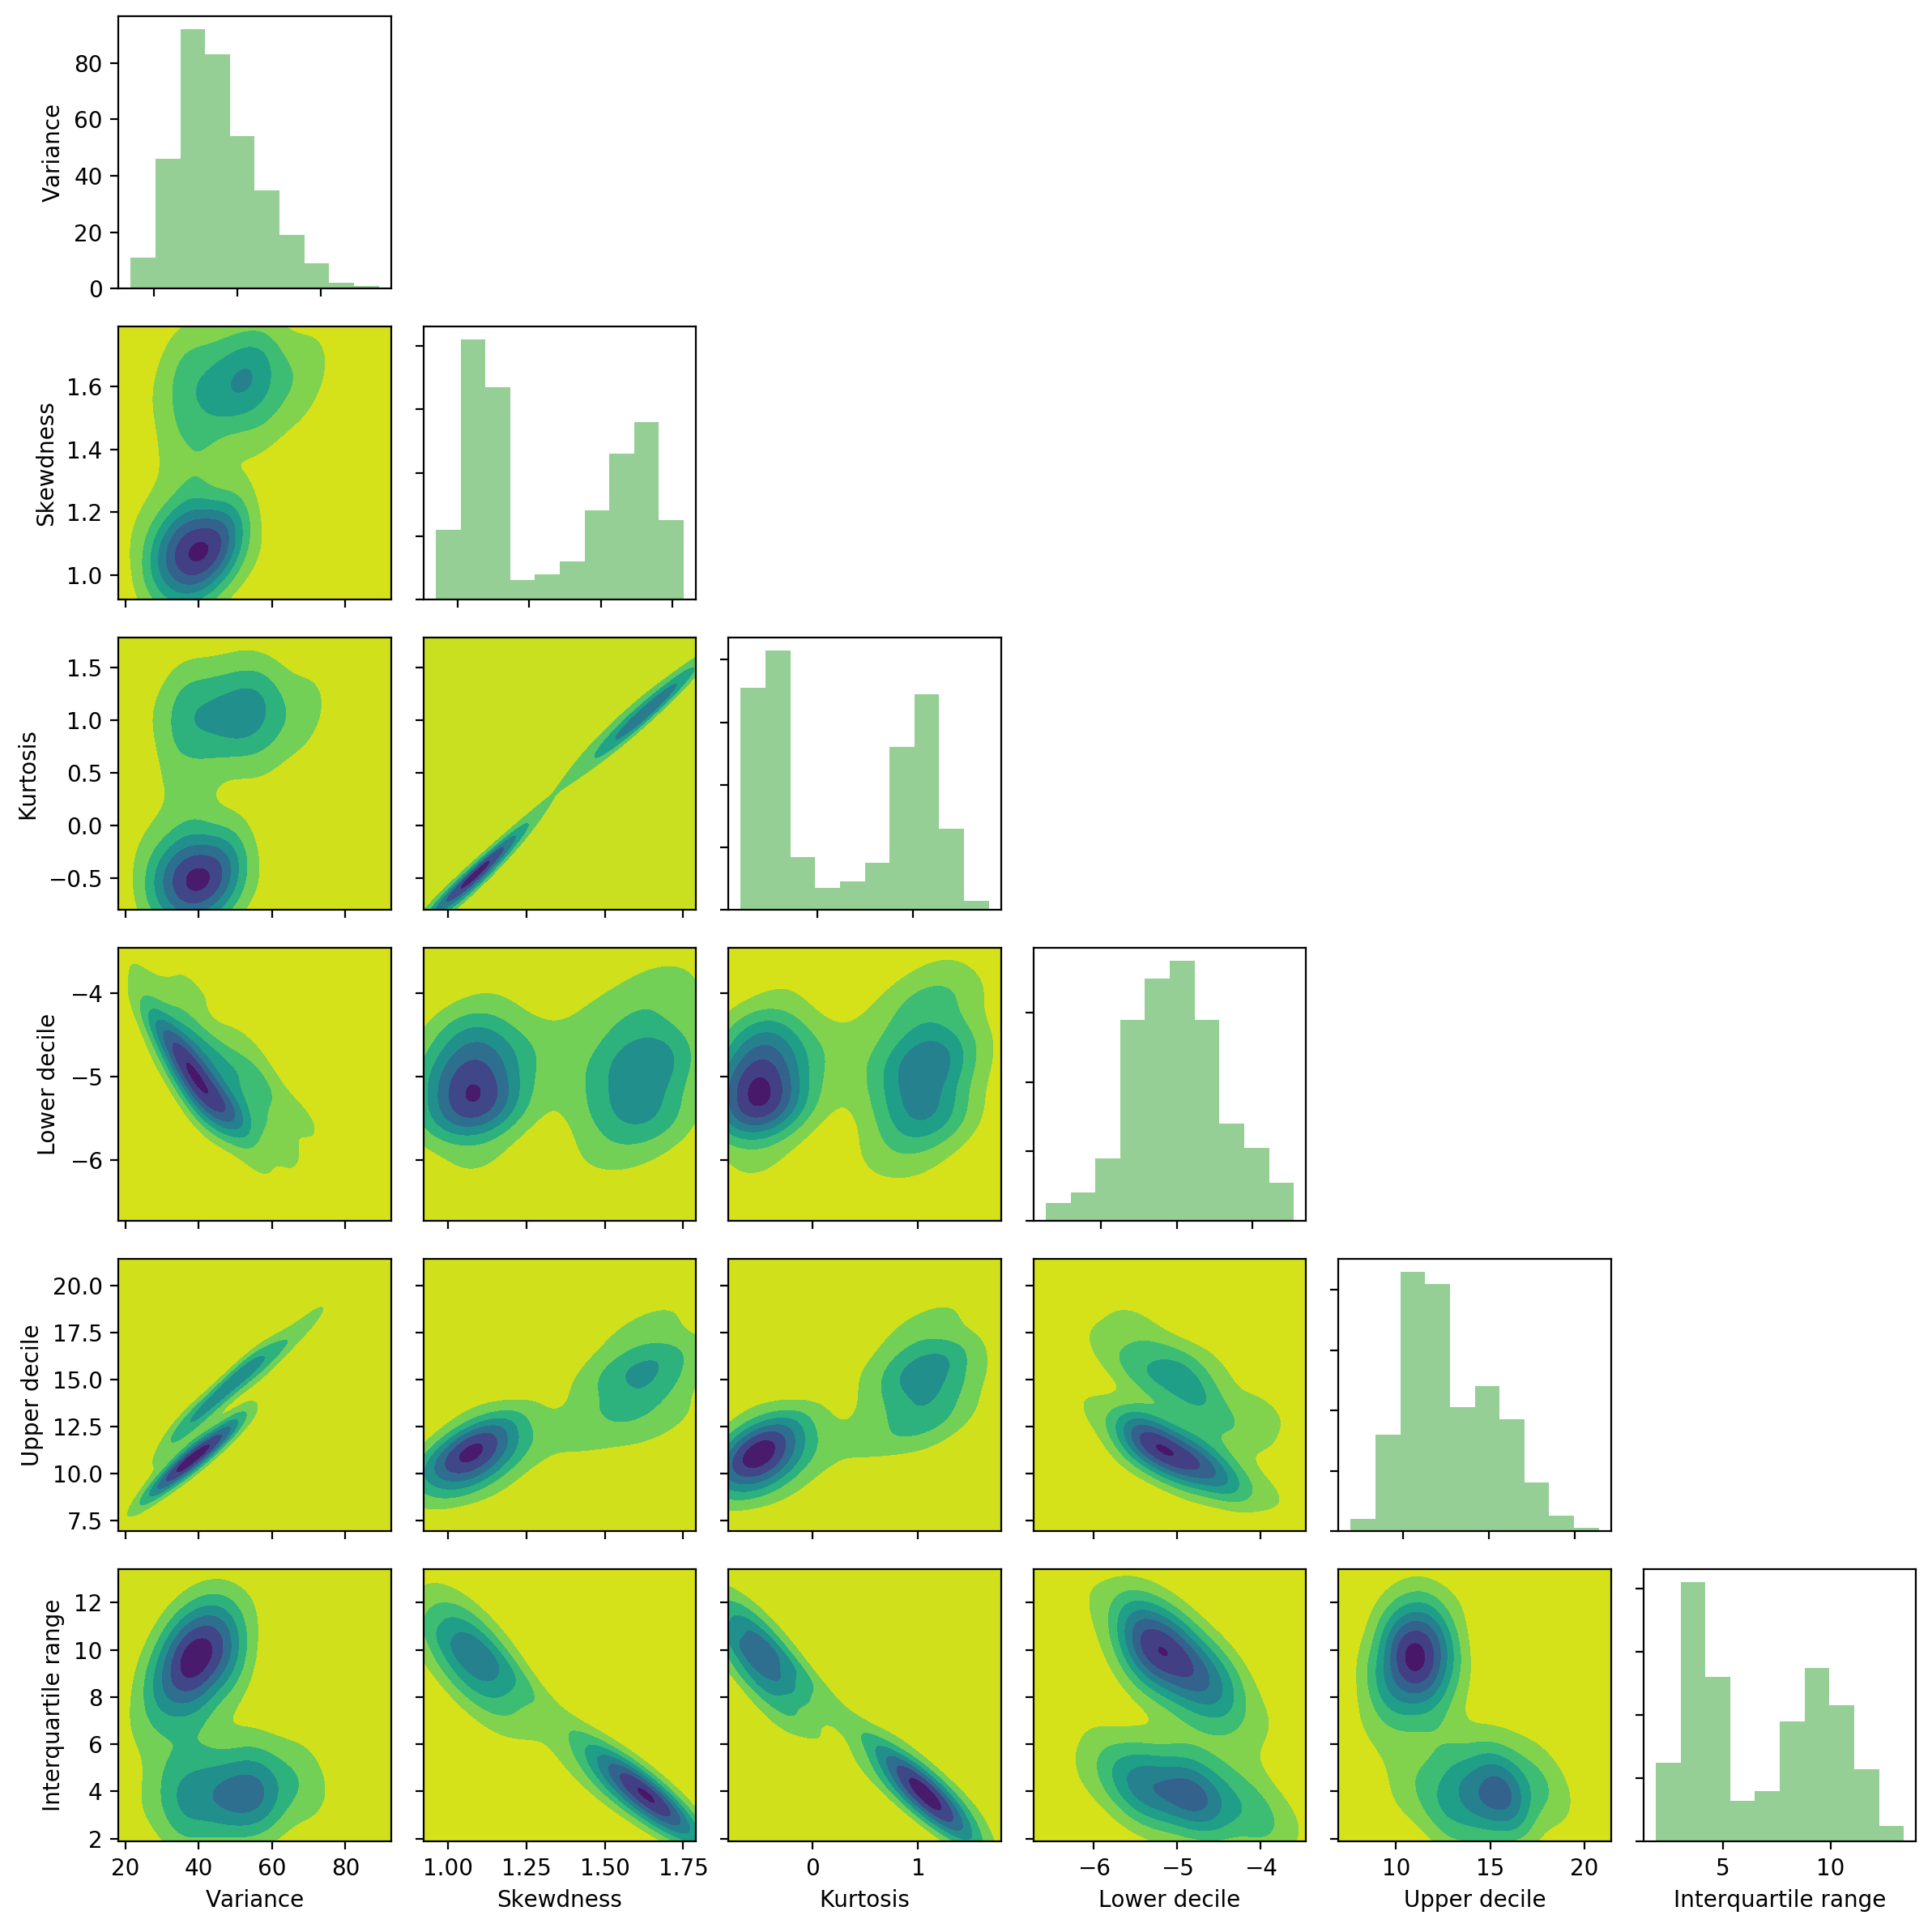

In [15]:
pair_plot(com_stats, method_colours["com"])

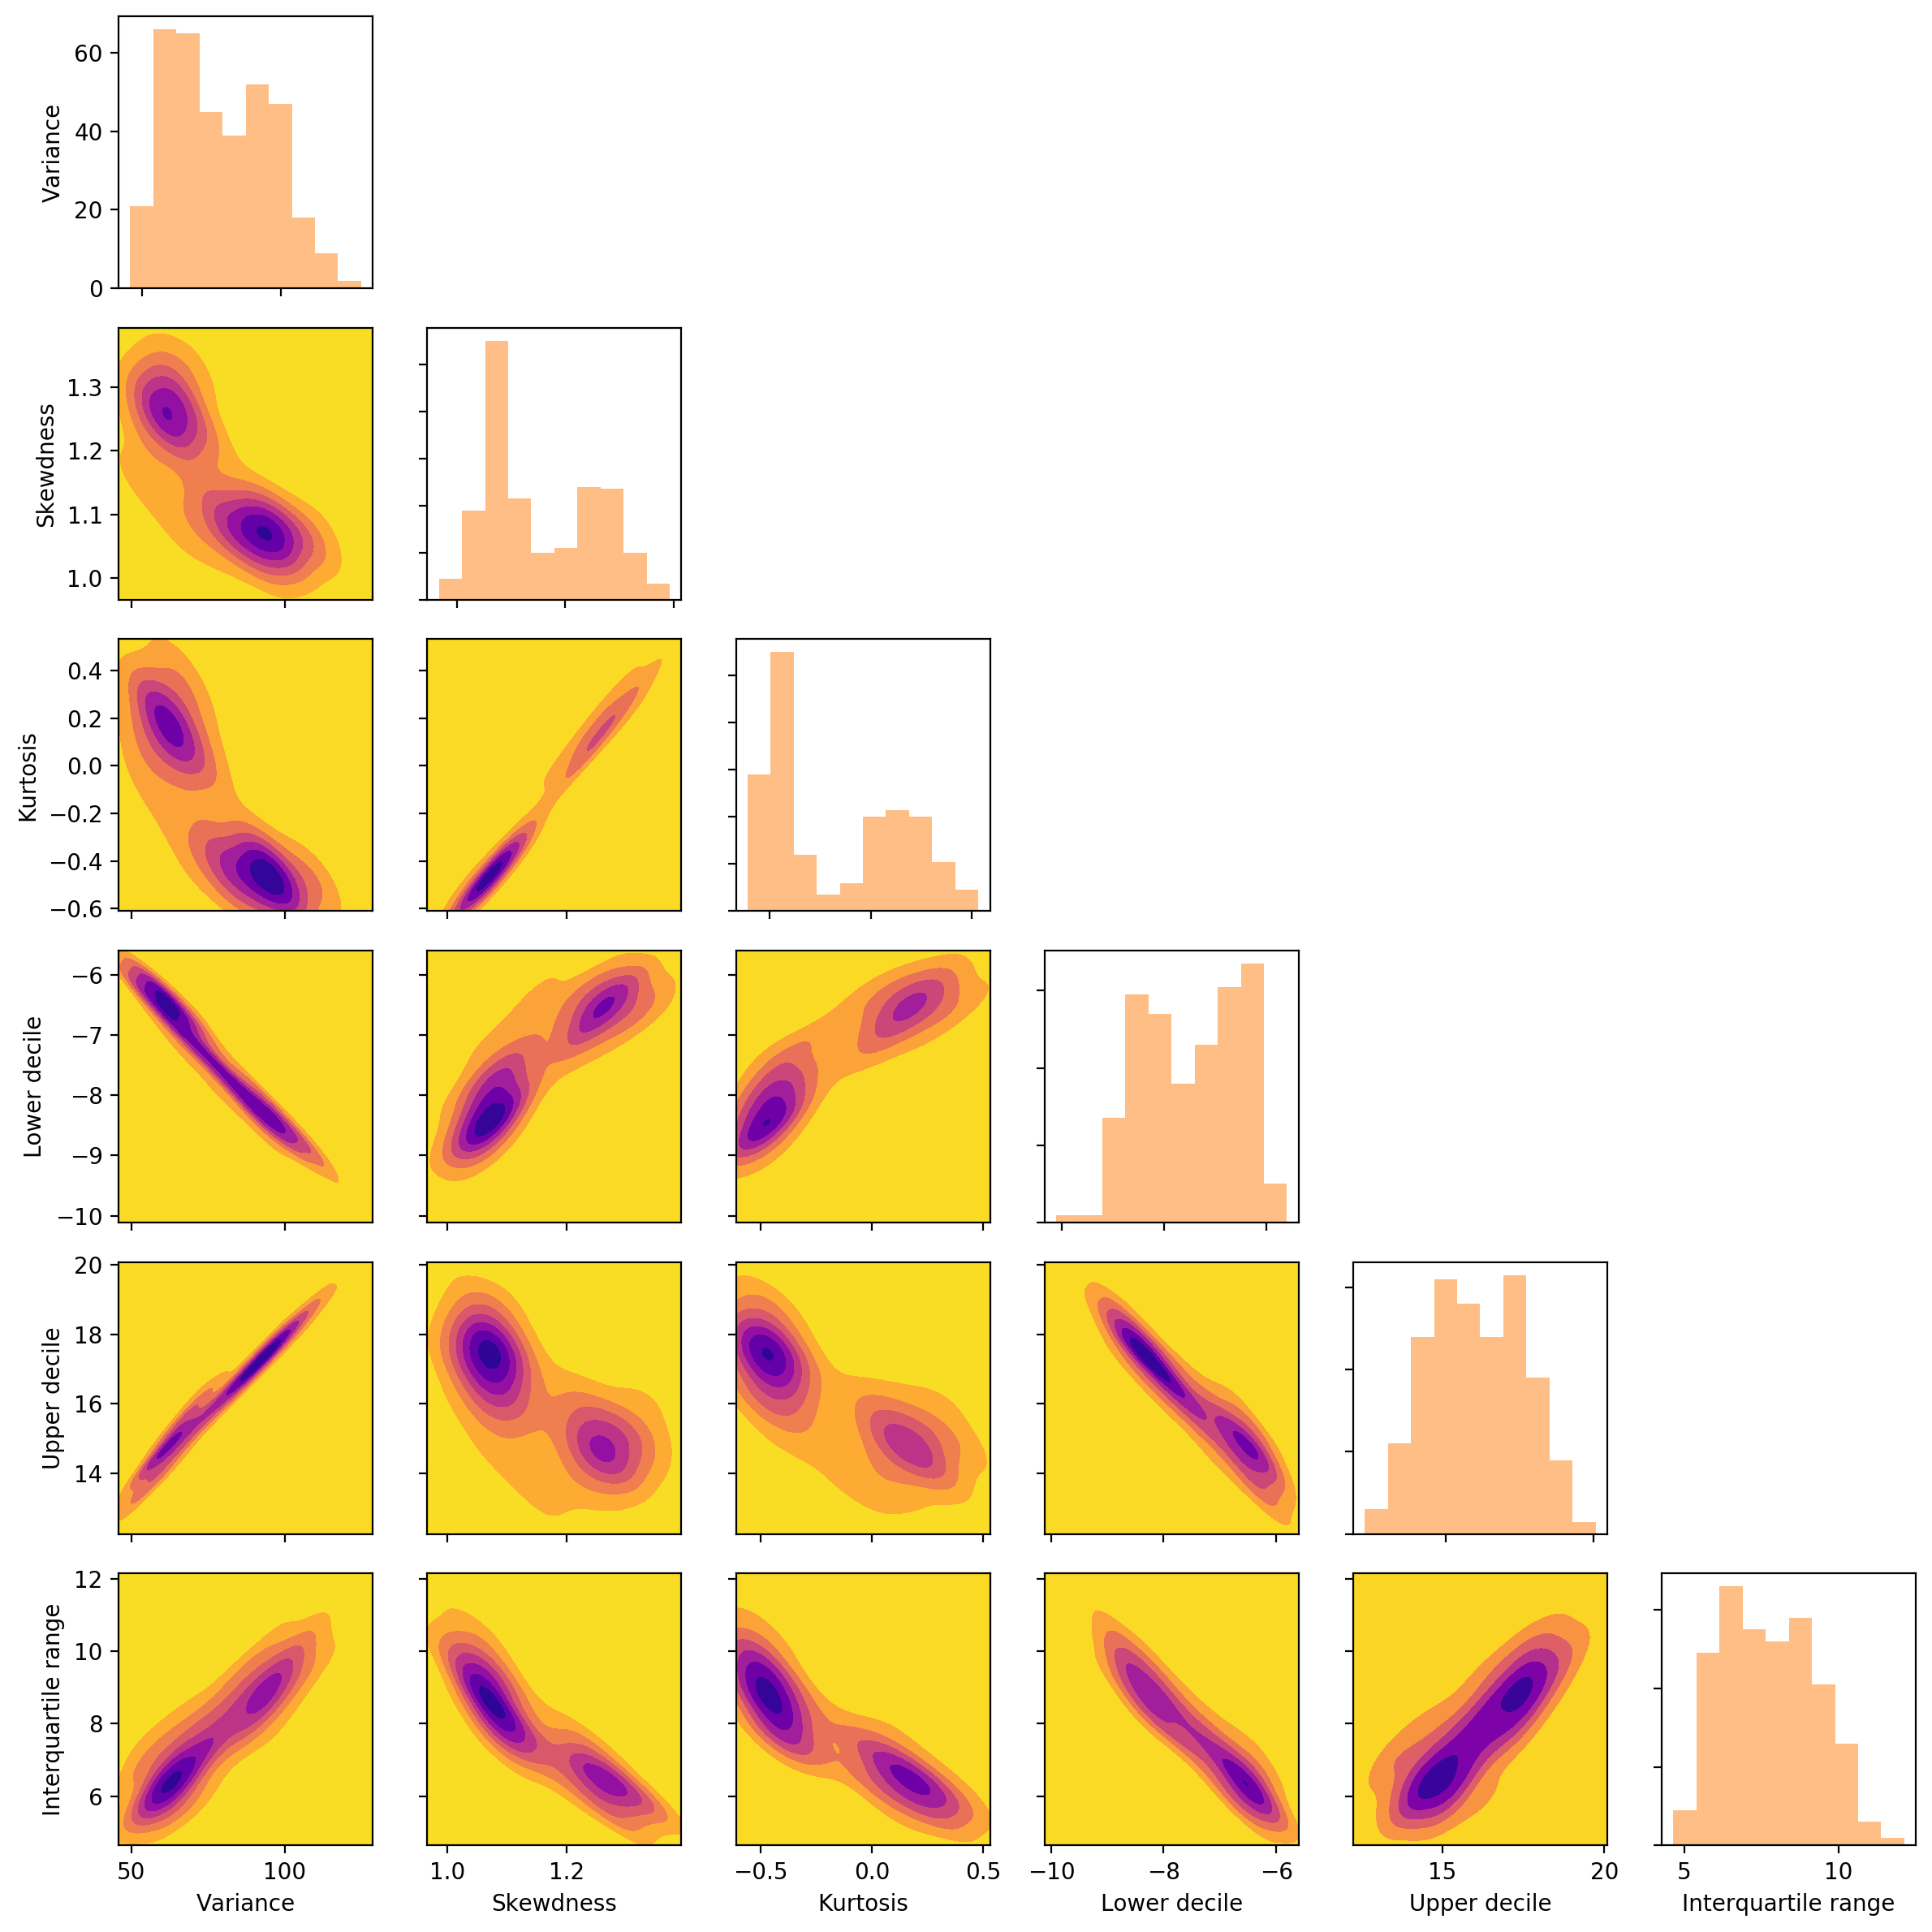

In [16]:
pair_plot(moc_stats, method_colours["moc"], plt.cm.plasma_r)